In [1]:
import numpy as np

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from tqdm.notebook import tqdm # Waiting/loading bar for loops

import multiprocess
from line_profiler import LineProfiler

In [2]:
# Own implementations
%load_ext autoreload
%autoreload 2
from data_generation import *
from linear_model import *
from transformation import *
from pipeline import Pipeline
from metric import *
from model_selection import *

In [3]:
# Misc
import sys
sys.path.insert(0, '../misc')
from plots import *

In [4]:
plt.style.use('../misc/report.mplstyle')

# Toggle to save plots as pdf
save=True
save_dir = "../../../tex/01_regression_resampling/img/"

In [5]:
# Data generation
N = 2000
p = 4
sigma = 0.1
x,y,z = random_x_y_franke(N, sigma=sigma)
X = generate_design_matrix(x, y, p)

In [6]:
def relative_error_sk(analytical_pipeline, sgd_sk_pipeline):
    return np.linalg.norm(analytical_pipeline.steps[-1].betas - sgd_sk_pipeline.steps[-1][1].coef_)/np.linalg.norm(analytical_pipeline.steps[-1].betas)
def relative_error_own(analytical_pipeline, sgd_pipeline):
    return np.linalg.norm(analytical_pipeline.steps[-1].betas - sgd_pipeline.steps[-1].betas)/np.linalg.norm(analytical_pipeline.steps[-1].betas)

## Ordinary Least Squares

In [7]:
# Compute "Ground Truth"
ols_pinv = Pipeline([Standardization(), 
                     OrdinaryLeastSquare(solver="pinv")])
ols_pinv.fit(X,z)

In [69]:
minibatches = N//2
max_epochs = 100
tol=None
seed=42
lr = 1e-5
profile=True

ols_sgd = Pipeline([Standardization(), 
                         OrdinaryLeastSquare(solver="sgd", 
                                             learning_rate=lambda t, grad: lr,
                                             max_epochs=max_epochs,
                                             batches=minibatches,
                                             seed=seed,
                                             tol=tol)])

ols_sgd.fit(X,z)

if profile:
    lp = LineProfiler()
    lp.add_function(OrdinaryLeastSquare.gradient_loss)
    lp.add_function(StochasticGradientDescent.minimize)
    lp.add_function(OrdinaryLeastSquare.fit)
    lp_wrapper=lp(ols_sgd.fit)
    lp_wrapper(X,z)
    lp.print_stats()
    


Timer unit: 1e-06 s

Total time: 0.6176 s
File: /Users/timzimmermann/Documents/PhD/courses/compsci/projects/01_regression_resampling/src/linear_model.py
Function: gradient_loss at line 60

Line #      Hits         Time  Per Hit   % Time  Line Contents
    60                                               def gradient_loss(self, X, y, p):
    61    100000     217538.0      2.2     35.2          y_pred = X @ p
    62    100000     400062.0      4.0     64.8          return 1.0 / X.shape[0] * X.T @ (y_pred - y)

Total time: 2.91008 s
File: /Users/timzimmermann/Documents/PhD/courses/compsci/projects/01_regression_resampling/src/linear_model.py
Function: fit at line 64

Line #      Hits         Time  Per Hit   % Time  Line Contents
    64                                               def fit(self, X, y):
    65                                           
    66         1        274.0    274.0      0.0          X, X_mean, y, y_mean = self._center_data(X, y)
    67                              

### Learning Rate Dependency 

In [10]:
minibatches = N
max_epochs = 2000
tol=None
seed=42

M = 20
lrs = np.logspace(-5,np.log10(0.06),M)

def compute_error(lr):
    # Pipeline using our SGD implmentation
    ols_sgd = Pipeline([Standardization(), 
                         OrdinaryLeastSquare(solver="sgd", 
                                             learning_rate=lambda t, grad: lr,
                                             max_epochs=max_epochs,
                                             batches=minibatches,
                                             seed=seed,
                                             tol=tol)])

    ols_sgd.fit(X,z)
    
    return relative_error_own(ols_pinv, ols_sgd)

pool = multiprocess.Pool()
result = tqdm(pool.imap(compute_error, lrs), total=M)
error_to_analytical =  list(result)

sk_error_to_analytical = np.empty(M)
for i, lr in enumerate(tqdm(lrs)):    
    # Pipeline using sklearn implementations
    ols_sk =make_pipeline(StandardScaler(), SGDRegressor(penalty=None, 
                                                     learning_rate="constant",
                                                     eta0=lr,
                                                     max_iter=max_epochs,
                                                     shuffle=True,
                                                     random_state=seed,
                                                     tol=tol))
    
    ols_sk.fit(X,z)
    sk_error_to_analytical[i] = relative_error_sk(ols_pinv, ols_sk)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

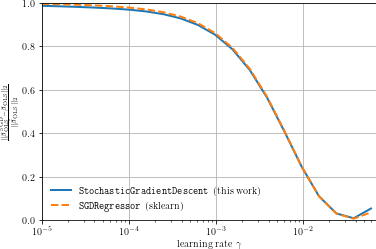

In [11]:
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_xlabel(r"learning rate  $\gamma$")
ax.set_ylabel(r"$\frac{||\hat{\beta}^\mathrm{SGD}_\mathrm{OLS} - \hat{\beta}_\mathrm{OLS}||_2}{||\hat{\beta}_\mathrm{OLS}||_2}$")
ax.plot(lrs, error_to_analytical, label=r"\texttt{StochasticGradientDescent} (this work)")
ax.plot(lrs, sk_error_to_analytical, ls="dashed", label=r"\texttt{SGDRegressor} (sklearn)")
ax.legend(*ax.get_legend_handles_labels())
ax.set_xlim([1e-5,0.07])
ax.set_ylim([0,1])
plt.show()

### Dependence on the Number of Mini Batches

In [12]:
minibatches = np.arange(0,N+1,100)
minibatches[0] = 1
max_epochs = 2000
tol=None
seed=42
lr = 0.03

def compute_error(batches):
    ols_sgd = Pipeline([Standardization(), 
                         OrdinaryLeastSquare(solver="sgd", 
                                             learning_rate=lambda t, grad: lr,
                                             max_epochs=max_epochs,
                                             batches=batches,
                                             seed=seed,
                                             tol=tol)])

    ols_sgd.fit(X,z)
    
    return relative_error_own(ols_pinv, ols_sgd)

M = minibatches.shape[0]
pool = multiprocess.Pool()
result = tqdm(pool.imap(compute_error, minibatches), total=M)
error_to_analytical_minibatches = list(result)

  0%|          | 0/21 [00:00<?, ?it/s]

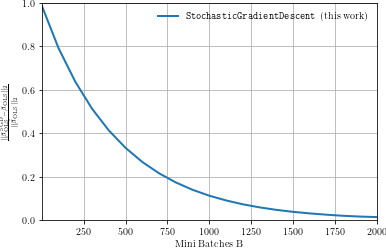

In [13]:
minibatches = np.arange(0,N+1,100)
minibatches[0] = 1

fig, ax = plt.subplots()
ax.set_xlabel(r"Mini Batches B")
ax.set_ylabel(r"$\frac{||\hat{\beta}^\mathrm{SGD}_\mathrm{OLS} - \hat{\beta}_\mathrm{OLS}||_2}{||\hat{\beta}_\mathrm{OLS}||_2}$")
ax.plot(minibatches, error_to_analytical_minibatches, label=r"\texttt{StochasticGradientDescent} (this work)")
ax.legend(*ax.get_legend_handles_labels())
ax.set_ylim([0,1])
plt.show()

### Dependence on the Number of Epochs

In [67]:
minibatches = N//10
max_epochs = np.arange(100,12000+100,100)
tol=None
seed=42
lr = 0.03

def compute_error(max_epoch):
    ols_sgd = Pipeline([Standardization(), 
                         OrdinaryLeastSquare(solver="sgd", 
                                             learning_rate=lambda t, grad: lr,
                                             max_epochs=max_epoch,
                                             batches=minibatches,
                                             seed=seed,
                                             tol=tol)])

    ols_sgd.fit(X,z)
    
    return relative_error_own(ols_pinv, ols_sgd)

M = max_epochs.shape[0]
pool = multiprocess.Pool()
result = tqdm(pool.imap(compute_error, max_epochs), total=M)
error_to_analytical_epochs = list(result)

  0%|          | 0/120 [00:00<?, ?it/s]

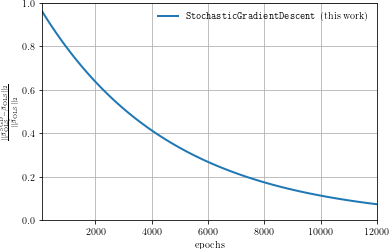

In [68]:
fig, ax = plt.subplots()
ax.set_xlabel(r"epochs")
ax.set_ylabel(r"$\frac{||\hat{\beta}^\mathrm{SGD}_\mathrm{OLS} - \hat{\beta}_\mathrm{OLS}||_2}{||\hat{\beta}_\mathrm{OLS}||_2}$")
ax.plot(max_epochs, error_to_analytical_epochs, label=r"\texttt{StochasticGradientDescent} (this work)")
ax.legend(*ax.get_legend_handles_labels())
ax.set_ylim([0,1])
plt.show()

### Adaptive Learning Rate Schedule

In [62]:
# Functors
def constant(t, grad):
    eta0 = 0.01 #1e-2
    return eta0

def invscaling(t, grad):
    eta0 = 0.01 #1e-2
    power_t = 0.125
    return eta0/t**power_t

# Generators
def adagrad():
    # initial learning rate
    eta0 = 0.01#1e-2
    # safe-guard against divergence
    epsilon = 1e-8
    g2_t = 0
    while True:
        gradient = yield
        g2_t += gradient**2
        yield eta0 / np.sqrt(epsilon + g2_t)
    
def rmsprop():
    # initial learning rate
    eta0 = 0.01#1e-3
    # decay constant
    beta=0.9 
    # safe-guard against divergence
    epsilon = 1e-8
    # moving average of second moment of gradient
    g2_t_avg = 0
    
    while True:
        gradient = yield
        g2_t_avg = beta*g2_t_avg + (1-beta)*gradient**2
        yield eta0 / np.sqrt(epsilon + g2_t_avg)

In [65]:
schedules = [constant, invscaling, adagrad(), rmsprop()]

minibatches = N//5
max_epochs = 5000
tol=None
seed=42

M = len(schedules)
error_to_analytical_schedules = np.empty(M)
for i,schedule in enumerate(tqdm(schedules)):
    ols_sgd = Pipeline([Standardization(), 
                         OrdinaryLeastSquare(solver="sgd", 
                                             learning_rate=schedule,
                                             max_epochs=max_epochs,
                                             batches=minibatches,
                                             seed=seed,
                                             tol=tol)])

    ols_sgd.fit(X,z)
    error_to_analytical_schedules[i] = relative_error_own(ols_pinv, ols_sgd)

  0%|          | 0/4 [00:00<?, ?it/s]

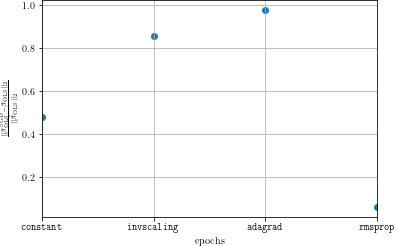

In [66]:
labels = [r"\texttt{constant}",r"\texttt{invscaling}",r"\texttt{adagrad}",r"\texttt{rmsprop}"]
fig, ax = plt.subplots()
ax.set_xlabel(r"epochs")
ax.set_ylabel(r"$\frac{||\hat{\beta}^\mathrm{SGD}_\mathrm{OLS} - \hat{\beta}_\mathrm{OLS}||_2}{||\hat{\beta}_\mathrm{OLS}||_2}$")
ax.scatter(labels,error_to_analytical_schedules)
plt.show()